The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.16.5


# Stochastic Gradient Descent
:label:`sec_sgd`

In earlier chapters we kept using stochastic gradient descent in our training procedure, however, without explaining why it works.
To shed some light on it,
we just described the basic principles of gradient descent
in :numref:`sec_gd`.
In this section, we go on to discuss
*stochastic gradient descent* in greater detail.


In [1]:
%matplotlib inline
import math
import tensorflow as tf
from d2l import tensorflow as d2l


## Stochastic Gradient Updates

In deep learning, the objective function is usually the average of the loss functions for each example in the training dataset. 
Given a training dataset of $n$ examples,
we assume that $f_i(\mathbf{x})$ is the loss function 
with respect to the training example of index $i$,
where $\mathbf{x}$ is the parameter vector.
Then we arrive at the objective function

$$f(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n f_i(\mathbf{x}).$$

The gradient of the objective function at $\mathbf{x}$ is computed as

$$\nabla f(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\mathbf{x}).$$

If gradient descent is used, the computational cost for each independent variable iteration is $\mathcal{O}(n)$, which grows linearly with $n$. Therefore, when the  training dataset is larger, the cost of gradient descent for each iteration will be higher.

Stochastic gradient descent (SGD) reduces computational cost at each iteration. At each iteration of stochastic gradient descent, we uniformly sample an index $i\in\{1,\ldots, n\}$ for data examples at random, and compute the gradient $\nabla f_i(\mathbf{x})$ to update $\mathbf{x}$:

$$\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla f_i(\mathbf{x}),$$

where $\eta$ is the learning rate. We can see that the computational cost for each iteration drops from $\mathcal{O}(n)$ of the gradient descent to the constant $\mathcal{O}(1)$. Moreover, we want to emphasize that the stochastic gradient $\nabla f_i(\mathbf{x})$ is an unbiased estimate of the full gradient $\nabla f(\mathbf{x})$ because

$$\mathbb{E}_i \nabla f_i(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\mathbf{x}) = \nabla f(\mathbf{x}).$$

This means that, on average, the stochastic gradient is a good estimate of the gradient.

Now, we will compare it with gradient descent by adding random noise with a mean of 0 and a variance of 1 to the gradient to simulate a stochastic gradient descent.


In [2]:
def f(x1, x2):  # Objective function
    return x1**2 + 2 * x2**2

def f_grad(x1, x2):  # Gradient of the objective function
    return 2 * x1, 4 * x2

In [3]:
def sgd(x1, x2, s1, s2, f_grad):
    g1, g2 = f_grad(x1, x2)
    # Simulate noisy gradient
    g1 += tf.random.normal([1], 0.0, 1)
    g2 += tf.random.normal([1], 0.0, 1)
    eta_t = eta * lr()
    return (x1 - eta_t * g1, x2 - eta_t * g2, 0, 0)

epoch 50, x1: -0.032286, x2: -0.192288


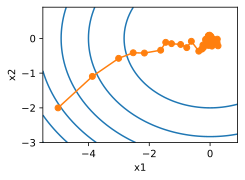

In [4]:
def constant_lr():
    return 1

eta = 0.1
lr = constant_lr  # Constant learning rate
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50, f_grad=f_grad))

As we can see, the trajectory of the variables in the stochastic gradient descent is much more noisy than the one we observed in gradient descent in :numref:`sec_gd`. This is due to the stochastic nature of the gradient. That is, even when we arrive near the minimum, we are still subject to the uncertainty injected by the instantaneous gradient via $\eta \nabla f_i(\mathbf{x})$. Even after 50 steps the quality is still not so good. Even worse, it will not improve after additional steps (we encourage you to experiment with a larger number of steps to confirm this). This leaves us with the only alternative: change the learning rate $\eta$. However, if we pick this too small, we will not make any meaningful progress initially. On the other hand, if we pick it too large, we will not get a good solution, as seen above. The only way to resolve these conflicting goals is to reduce the learning rate *dynamically* as optimization progresses.

This is also the reason for adding a learning rate function `lr` into the `sgd` step function. In the example above any functionality for learning rate scheduling lies dormant as we set the associated `lr` function to be constant.

## Dynamic Learning Rate

Replacing $\eta$ with a time-dependent learning rate $\eta(t)$ adds to the complexity of controlling convergence of an optimization algorithm. In particular, we need to figure out how rapidly $\eta$ should decay. If it is too quick, we will stop optimizing prematurely. If we decrease it too slowly, we waste too much time on optimization. The following are a few basic strategies that are used in adjusting $\eta$ over time (we will discuss more advanced strategies later):

$$
\begin{aligned}
    \eta(t) & = \eta_i \text{ if } t_i \leq t \leq t_{i+1}  && \text{piecewise constant} \\
    \eta(t) & = \eta_0 \cdot e^{-\lambda t} && \text{exponential decay} \\
    \eta(t) & = \eta_0 \cdot (\beta t + 1)^{-\alpha} && \text{polynomial decay}
\end{aligned}
$$

In the first *piecewise constant* scenario we decrease the learning rate, e.g., whenever progress in optimization stalls. This is a common strategy for training deep networks. Alternatively we could decrease it much more aggressively by an *exponential decay*. Unfortunately this often leads to premature stopping before the algorithm has converged. A popular choice is *polynomial decay* with $\alpha = 0.5$. In the case of convex optimization there are a number of proofs that show that this rate is well behaved. 

Let us see what the exponential decay looks like in practice.


epoch 1000, x1: -0.726561, x2: 0.007033


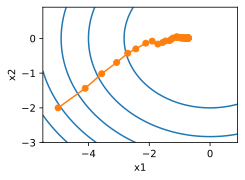

In [5]:
def exponential_lr():
    # Global variable that is defined outside this function and updated inside
    global t
    t += 1
    return math.exp(-0.1 * t)

t = 1
lr = exponential_lr
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=1000, f_grad=f_grad))

As expected, the variance in the parameters is significantly reduced. However, this comes at the expense of failing to converge to the optimal solution $\mathbf{x} = (0, 0)$. Even after 1000 iteration steps are we are still very far away from the optimal solution. Indeed, the algorithm fails to converge at all. On the other hand, if we use a polynomial decay where the learning rate decays with the inverse square root of the number of steps, convergence gets better after only 50 steps.


epoch 50, x1: 0.086213, x2: 0.096072


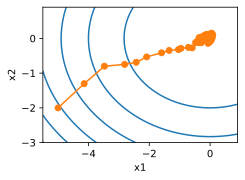

In [6]:
def polynomial_lr():
    # Global variable that is defined outside this function and updated inside
    global t
    t += 1
    return (1 + 0.1 * t)**(-0.5)

t = 1
lr = polynomial_lr
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50, f_grad=f_grad))

There exist many more choices for how to set the learning rate. For instance, we could start with a small rate, then rapidly ramp up and then decrease it again, albeit more slowly. We could even alternate between smaller and larger learning rates. There exists a large variety of such schedules. For now let us focus on learning rate schedules for which a comprehensive theoretical analysis is possible, i.e., on learning rates in a convex setting. For general nonconvex problems it is very difficult to obtain meaningful convergence guarantees, since in general minimizing nonlinear nonconvex problems is NP hard. For a survey see e.g., the excellent [lecture notes](https://www.stat.cmu.edu/~ryantibs/convexopt-F15/lectures/26-nonconvex.pdf) of Tibshirani 2015.



## Convergence Analysis for Convex Objectives

The following convergence analysis of stochastic gradient descent for convex objective functions
is optional and primarily serves to convey more intuition about the problem. 
We limit ourselves to one of the simplest proofs :cite:`Nesterov.Vial.2000`.
Significantly more advanced proof techniques exist, e.g., whenever the objective function is particularly well behaved. 


Suppose that the objective function $f(\boldsymbol{\xi}, \mathbf{x})$ is convex in $\mathbf{x}$
for all $\boldsymbol{\xi}$.
More concretely,
we consider the stochastic gradient descent update:

$$\mathbf{x}_{t+1} = \mathbf{x}_{t} - \eta_t \partial_\mathbf{x} f(\boldsymbol{\xi}_t, \mathbf{x}),$$

where $f(\boldsymbol{\xi}_t, \mathbf{x})$
is the objective function 
with respect to the training example $\boldsymbol{\xi}_t$
drawn from some distribution
at step $t$ and $\mathbf{x}$ is the model parameter.
Denote by

$$R(\mathbf{x}) = E_{\boldsymbol{\xi}}[f(\boldsymbol{\xi}, \mathbf{x})]$$

the expected risk and by $R^*$ its minimum with regard to $\mathbf{x}$. Last let $\mathbf{x}^*$ be the minimizer (we assume that it exists within the domain where $\mathbf{x}$ is defined). In this case we can track the distance between the current parameter $\mathbf{x}_t$ at time $t$ and the risk minimizer $\mathbf{x}^*$ and see whether it improves over time:

$$\begin{aligned}    &\|\mathbf{x}_{t+1} - \mathbf{x}^*\|^2 \\ =& \|\mathbf{x}_{t} - \eta_t \partial_\mathbf{x} f(\boldsymbol{\xi}_t, \mathbf{x}) - \mathbf{x}^*\|^2 \\    =& \|\mathbf{x}_{t} - \mathbf{x}^*\|^2 + \eta_t^2 \|\partial_\mathbf{x} f(\boldsymbol{\xi}_t, \mathbf{x})\|^2 - 2 \eta_t    \left\langle \mathbf{x}_t - \mathbf{x}^*, \partial_\mathbf{x} f(\boldsymbol{\xi}_t, \mathbf{x})\right\rangle.   \end{aligned}$$
:eqlabel:`eq_sgd-xt+1-xstar`

We assume that the $L_2$ norm of stochastic gradient $\partial_\mathbf{x} f(\boldsymbol{\xi}_t, \mathbf{x})$ is bounded  by some  constant $L$, hence we have that

$$\eta_t^2 \|\partial_\mathbf{x} f(\boldsymbol{\xi}_t, \mathbf{x})\|^2 \leq \eta_t^2 L^2.$$
:eqlabel:`eq_sgd-L`


We are mostly interested in how the distance between $\mathbf{x}_t$ and $\mathbf{x}^*$ changes *in expectation*. In fact, for any specific sequence of steps the distance might well increase, depending on whichever $\boldsymbol{\xi}_t$ we encounter. Hence we need to bound the inner product. 
Since for any convex function $f$ it holds that
$f(\mathbf{y}) \geq f(\mathbf{x}) + \langle f'(\mathbf{x}), \mathbf{y} - \mathbf{x} \rangle$
for all $\mathbf{x}$ and $\mathbf{y}$,
by convexity we have

$$f(\boldsymbol{\xi}_t, \mathbf{x}^*) \geq f(\boldsymbol{\xi}_t, \mathbf{x}_t) + \left\langle \mathbf{x}^* - \mathbf{x}_t, \partial_{\mathbf{x}} f(\boldsymbol{\xi}_t, \mathbf{x}_t) \right\rangle.$$
:eqlabel:`eq_sgd-f-xi-xstar`

Plugging both inequalities :eqref:`eq_sgd-L` and :eqref:`eq_sgd-f-xi-xstar` into :eqref:`eq_sgd-xt+1-xstar` we obtain a bound on the distance between parameters at time $t+1$ as follows:

$$\|\mathbf{x}_{t} - \mathbf{x}^*\|^2 - \|\mathbf{x}_{t+1} - \mathbf{x}^*\|^2 \geq 2 \eta_t (f(\boldsymbol{\xi}_t, \mathbf{x}_t) - f(\boldsymbol{\xi}_t, \mathbf{x}^*)) - \eta_t^2 L^2.$$
:eqlabel:`eqref_sgd-xt-diff`

This means that we make progress as long as the  difference between current loss and the optimal loss outweighs $\eta_t L^2/2$. Since this difference is bound to converge to zero it follows that the learning rate $\eta_t$ also needs to *vanish*.

Next we take expectations over :eqref:`eqref_sgd-xt-diff`. This yields

$$E\left[\|\mathbf{x}_{t} - \mathbf{x}^*\|^2\right] - E\left[\|\mathbf{x}_{t+1} - \mathbf{x}^*\|^2\right] \geq 2 \eta_t [E[R(\mathbf{x}_t)] - R^*] -  \eta_t^2 L^2.$$

The last step involves summing over the inequalities for $t \in \{1, \ldots, T\}$. Since the sum telescopes and by dropping the lower term we obtain

$$\|\mathbf{x}_1 - \mathbf{x}^*\|^2 \geq 2 \left (\sum_{t=1}^T   \eta_t \right) [E[R(\mathbf{x}_t)] - R^*] - L^2 \sum_{t=1}^T \eta_t^2.$$
:eqlabel:`eq_sgd-x1-xstar`

Note that we exploited that $\mathbf{x}_1$ is given and thus the expectation can be dropped. Last define

$$\bar{\mathbf{x}} \stackrel{\mathrm{def}}{=} \frac{\sum_{t=1}^T \eta_t \mathbf{x}_t}{\sum_{t=1}^T \eta_t}.$$

Since 

$$E\left(\frac{\sum_{t=1}^T \eta_t R(\mathbf{x}_t)}{\sum_{t=1}^T \eta_t}\right) = \frac{\sum_{t=1}^T \eta_t E[R(\mathbf{x}_t)]}{\sum_{t=1}^T \eta_t} = E[R(\mathbf{x}_t)],$$

by Jensen's inequality (setting $i=t$, $\alpha_i = \eta_t/\sum_{t=1}^T \eta_t$ in :eqref:`eq_jensens-inequality`) and convexity of $R$ it follows that $E[R(\mathbf{x}_t)] \geq E[R(\bar{\mathbf{x}})]$, thus

$$\sum_{t=1}^T \eta_t E[R(\mathbf{x}_t)] \geq \sum_{t=1}^T \eta_t  E\left[R(\bar{\mathbf{x}})\right].$$

Plugging this into the inequality :eqref:`eq_sgd-x1-xstar` yields the bound

$$
\left[E[\bar{\mathbf{x}}]\right] - R^* \leq \frac{r^2 + L^2 \sum_{t=1}^T \eta_t^2}{2 \sum_{t=1}^T \eta_t},
$$

where $r^2 \stackrel{\mathrm{def}}{=} \|\mathbf{x}_1 - \mathbf{x}^*\|^2$ is a bound on the distance between the initial choice of parameters and the final outcome. In short, the speed of convergence depends on how 
the norm of stochastic gradient is bounded ($L$) and how far away from optimality the initial parameter value is ($r$). Note that the bound is in terms of $\bar{\mathbf{x}}$ rather than $\mathbf{x}_T$. This is the case since $\bar{\mathbf{x}}$ is a smoothed version of the optimization path. 
Whenever $r, L$, and $T$ are known we can pick the learning rate $\eta = r/(L \sqrt{T})$. This yields as upper bound $rL/\sqrt{T}$. That is, we converge with rate $\mathcal{O}(1/\sqrt{T})$ to the optimal solution.





## Stochastic Gradients and Finite Samples

So far we have played a bit fast and loose when it comes to talking about stochastic gradient descent. We posited that we draw instances $x_i$, typically with labels $y_i$ from some distribution $p(x, y)$ and that we use this to update the model parameters in some manner. In particular, for a finite sample size we simply argued that the discrete distribution $p(x, y) = \frac{1}{n} \sum_{i=1}^n \delta_{x_i}(x) \delta_{y_i}(y)$
for some functions $\delta_{x_i}$ and $\delta_{y_i}$
allows us to perform stochastic gradient descent over it.

However, this is not really what we did. In the toy examples in the current section we simply added noise to an otherwise non-stochastic gradient, i.e., we pretended to have pairs $(x_i, y_i)$. It turns out that this is justified here (see the exercises for a detailed discussion). More troubling is that in all previous discussions we clearly did not do this. Instead we iterated over all instances *exactly once*. To see why this is preferable consider the converse, namely that we are sampling $n$ observations from the discrete distribution *with replacement*. The probability of choosing an element $i$ at random is $1/n$. Thus to choose it *at least* once is

$$P(\mathrm{choose~} i) = 1 - P(\mathrm{omit~} i) = 1 - (1-1/n)^n \approx 1-e^{-1} \approx 0.63.$$

A similar reasoning shows that the probability of picking some sample (i.e., training example) *exactly once* is given by 

$${n \choose 1} \frac{1}{n} \left(1-\frac{1}{n}\right)^{n-1} = \frac{n}{n-1} \left(1-\frac{1}{n}\right)^{n} \approx e^{-1} \approx 0.37.$$ 

This leads to an increased variance and decreased data efficiency relative to sampling *without replacement*. Hence, in practice we perform the latter (and this is the default choice throughout this book). Last note that repeated passes through the training dataset traverse it in a *different* random order.


## Summary

* For convex problems we can prove that for a wide choice of learning rates stochastic gradient descent will converge to the optimal solution.
* For deep learning this is generally not the case. However, the analysis of convex problems gives us useful insight into how to approach optimization, namely to reduce the learning rate progressively, albeit not too quickly.
* Problems occur when the learning rate is too small or too large. In practice  a suitable learning rate is often found only after multiple experiments.
* When there are more examples in the training dataset, it costs more to compute each iteration for gradient descent, so stochastic gradient descent is preferred in these cases.
* Optimality guarantees for stochastic gradient descent are in general not available in nonconvex cases since the number of local minima that require checking might well be exponential.




## Exercises

1. Experiment with different learning rate schedules for stochastic gradient descent and with different numbers of iterations. In particular, plot the distance from the optimal solution $(0, 0)$ as a function of the number of iterations.
1. Prove that for the function $f(x_1, x_2) = x_1^2 + 2 x_2^2$ adding normal noise to the gradient is equivalent to minimizing a loss function $f(\mathbf{x}, \mathbf{w}) = (x_1 - w_1)^2 + 2 (x_2 - w_2)^2$ where $\mathbf{x}$ is drawn from a normal distribution.
1. Compare convergence of stochastic gradient descent when you sample from $\{(x_1, y_1), \ldots, (x_n, y_n)\}$ with replacement and when you sample without replacement.
1. How would you change the stochastic gradient descent solver if some gradient (or rather some coordinate associated with it) was consistently larger than all the other gradients?
1. Assume that $f(x) = x^2 (1 + \sin x)$. How many local minima does $f$ have? Can you change $f$ in such a way that to minimize it one needs to evaluate all the local minima?


[Discussions](https://discuss.d2l.ai/t/1067)
